# imports

In [2]:
import sys
import random
from pathlib import Path
from torchvision import transforms

In [3]:
%reload_ext autoreload
%autoreload 2
sys.path.append('../') # go back one dir 
from Helper_Modules.dataset_creation import find_cells_by_keyword, apply_multi_transforms, create_quality_dataset
from Helper_Modules.data_setups import load_and_log_IF
from Helper_Modules.resize import to_square_save
from Helper_Modules.model_setups import efficientNet_b0, build_model_and_log

c:\Users\AbdelrahmanE\AppData\Local\anaconda3\envs\pytorchv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
file_path = "../data/allData/Data_Map.xlsx" 

# get the paths of the splits

## test split

In [39]:
test_ear_bad = find_cells_by_keyword(file_path, {2:"very_bad", 3:"Ear", 4:"second"})
test_Nose_bad = find_cells_by_keyword(file_path,{2: "very_bad",3: "Nose" ,4: "second"} )
test_Vocal_bad = find_cells_by_keyword(file_path, {2:"very_bad", 3:"Vocal"}) # second and first because of the limited badquality vocal folds images 
all_test_bad = test_ear_bad + test_Nose_bad + test_Vocal_bad
len(all_test_bad)

61

In [29]:
# test good split
test_ear_good = find_cells_by_keyword(file_path, {2:"very_good",3: "Ear" ,4: "second"} )
test_Nose_good = find_cells_by_keyword(file_path,{2:"very_good", 3:"Nose" , 4:"second" })
test_Vocal_good = find_cells_by_keyword(file_path,{2:"very_good",3: "Vocal" ,4: "second"} )
all_test_good = test_ear_good + test_Nose_good + test_Vocal_good
len(test_ear_good), len(test_Nose_good), len(test_Vocal_good)

(23, 16, 22)

## train split

In [30]:
# very bad ear images which are not in the test split will be added to the train split without preproccesing
ear_verybad = find_cells_by_keyword(file_path, {2:"very_bad",3: "Ear" , 4:"first"} )
nose_verybad = find_cells_by_keyword(file_path, {2:"very_bad", 3:"Nose" , 4:"first"} )
bad_raw = ear_verybad + nose_verybad
# no vocal folds very bad images, all the images have been used in the test due to limmeted data, 
len(bad_raw)

45

In [5]:
# bad train: 
# bad_to_transform = find_cells_by_keyword(file_path, {2:"bad", 4:"first"} ) # get them separately to keep an overview on each organ
ear_bad = find_cells_by_keyword(file_path, {2:"bad", 3:"Ear" , 4:"first"} ) 
nose_bad = find_cells_by_keyword(file_path, {2:"bad", 3:"Nose" , 4:"first"} ) 
vocal_bad = find_cells_by_keyword(file_path, {2:"bad", 3:"vocal" , 4:"first"} ) 
bad_to_transform = ear_bad + nose_bad + vocal_bad
random.seed(42)
random.shuffle(bad_to_transform)
len(ear_bad), len(nose_bad), len(vocal_bad), len(bad_to_transform)

(87, 134, 1, 222)

In [32]:
# very good train. To gurantee not transfering it to bad  
# verygood_train = find_cells_by_keyword(file_path, {2:"very_good", 4:"first"})
ear_verygood = find_cells_by_keyword(file_path, {2:"very_good", 3:"Ear" , 4:"first"})
nose_verygood = find_cells_by_keyword(file_path, {2:"very_good", 3:"Nose" , 4:"first"})
vocal_verygood = find_cells_by_keyword(file_path, {2:"very_good", 3:"vocal" , 4:"first"}) 
verygood_train = ear_verygood + nose_verygood + vocal_verygood
len(ear_verygood), len(nose_verygood), len(vocal_verygood), len(verygood_train)

(84, 42, 40, 166)

In [6]:
# good train  
# all_good_train = find_cells_by_keyword(file_path, {2:"good", 4:"first"}) 
ear_good = find_cells_by_keyword(file_path, {2:"good", 3:"Ear" , 4:"first"}) 
nose_good = find_cells_by_keyword(file_path, {2:"good", 3:"Nose" , 4:"first"}) 
vocal_good = find_cells_by_keyword(file_path, {2:"good", 3:"vocal" , 4:"first"}) 
all_good_train = ear_good + nose_good + vocal_good
random.seed(42)
random.shuffle(all_good_train)
len(ear_good), len(nose_good), len(vocal_good), len(all_good_train)

(62, 237, 141, 440)

In [7]:
# 72 images are needed to balance the bad class by 339
good_to_transform = all_good_train[200:272]
good_to_transform

['../data/allData/VocalFolds/Vocal_1/Vocal_1_014.png',
 '../data/allData/Nose/Nose_3_2/Nose_3_2_065.png',
 '../data/allData/Nose/Nose_1_2/Nose_1_2_022.png',
 '../data/allData/VocalFolds/Vocal_1/Vocal_1_030.png',
 '../data/allData/VocalFolds/Vocal_1/Vocal_1_027.png',
 '../data/allData/Ear/Ear_2_2/Ear_2_2_042.png',
 '../data/allData/Nose/Nose_2_1/Nose_2_1_001.png',
 '../data/allData/Nose/Nose_2_2/Nose_2_2_070.png',
 '../data/allData/Nose/Nose_1_1/Nose_1_1_035.png',
 '../data/allData/Ear/Ear_1_1/Ear_1_1_059.png',
 '../data/allData/Ear/Ear_1_2/Ear_1_2_020.png',
 '../data/allData/VocalFolds/Vocal_1/Vocal_1_021.png',
 '../data/allData/VocalFolds/Vocal_4/Vocal_4_039.png',
 '../data/allData/VocalFolds/Vocal_1/Vocal_1_041.png',
 '../data/allData/VocalFolds/Vocal_2/Vocal_2_020.png',
 '../data/allData/Ear/Ear_1_2/Ear_1_2_025.png',
 '../data/allData/VocalFolds/Vocal_3/Vocal_3_019.png',
 '../data/allData/VocalFolds/Vocal_1/Vocal_1_011.png',
 '../data/allData/Nose/Nose_3_2/Nose_3_2_008.png',
 '../da

In [8]:
# the goal is to have 339 images in each train class
to_transform = bad_to_transform + good_to_transform
len(to_transform) # + 45 very bad images = 339 bad images in the training set

294

In [36]:
# getting rid of the good images to be used as bad
good_train = [item for item in all_good_train if item not in good_to_transform]
len(good_train)

368

In [37]:
# all good paths. Later 339 images will be taken
all_good_paths = good_train + verygood_train
random.seed(42)
random.shuffle(all_good_paths)
len(all_good_paths)

534

# applying transforms on the bad quality images 

In [9]:
random.seed(42)
transformed_images = apply_multi_transforms(to_transform, 2, random.randint(40, 50), random.randint(30, 50))
len(transformed_images)

294

## plotting some transformed images

In [1]:
# TODO: make a helper function which can plot any list
import matplotlib.pyplot as plt
def plot_list(images_list, figsize):
    """width gotta be 15 (15, ..)"""
    # height = math.ceil(len(paths_list)/5) * 5 TODO: look for another method 
    plt.figure(figsize=figsize)
    index = 1
    for image in images_list:
        if index < 61:
          plt.subplot(12, 5, index)
          plt.imshow(image)
          plt.axis(False)
          index+=1
        else:
           break

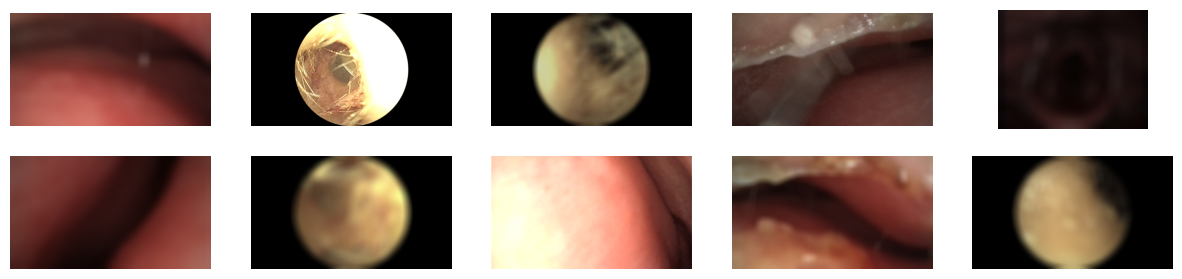

In [12]:
plot_list(transformed_images[30:33] + transformed_images[103:106] + transformed_images[150:154], (15, 22))

# create the quality dataset

In [43]:
create_quality_dataset('quality_0',all_test_good, all_test_bad, all_good_paths[100:439], bad_raw, transformed_images, to_transform )

In [45]:
dataset_0_paths = list(Path("data\\quality_0").glob("*\\*\\*.png"))
len(dataset_0_paths)

800

In [46]:
for im in dataset_0_paths:
    to_square_save(im, "data\\quality_0\\")

# log into WandB

In [48]:
quality_0_path = "data\\quality_0"
quality_0_config = dict(dataset_dir=quality_0_path,
                      project_name="quality-classifier-1",
                      transforms_=[transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])],
                      name="quality_0",
                      description="the 0th version of the quality dataset")
quality_0_config

{'dataset_dir': 'data\\quality_0',
 'project_name': 'quality-classifier-1',
 'transforms_': [ToTensor(),
  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])],
 'name': 'quality_0',
 'description': 'the 0th version of the quality dataset'}

In [49]:
load_and_log_IF(quality_0_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elsharkawi99 (d-ml). Use `wandb login --relogin` to force relogin


# log EfficientNetB0 to WandB

In [5]:
model_config = dict(project_name="Quality-Classifier-1",
                    model_name="efficientNet_b0",
                    description="efficientnet unfrozen",
                    freeze_layers=False,
                    num_classes=2)

model_ = efficientNet_b0(model_config['freeze_layers'],model_config['num_classes'], 'cpu')
model_initialized = build_model_and_log(model_,model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elsharkawi99 (d-ml). Use `wandb login --relogin` to force relogin
